<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#importations" data-toc-modified-id="importations-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>importations</a></span></li><li><span><a href="#Jeu-de-données" data-toc-modified-id="Jeu-de-données-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Jeu de données</a></span></li><li><span><a href="#Data-Augmentation" data-toc-modified-id="Data-Augmentation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Augmentation</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#Traitements" data-toc-modified-id="Traitements-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Traitements</a></span></li><li><span><a href="#Modèles" data-toc-modified-id="Modèles-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Modèles</a></span><ul class="toc-item"><li><span><a href="#DenseNet201" data-toc-modified-id="DenseNet201-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>DenseNet201</a></span></li><li><span><a href="#EfficientNetB7" data-toc-modified-id="EfficientNetB7-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>EfficientNetB7</a></span></li><li><span><a href="#Stacking" data-toc-modified-id="Stacking-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Stacking</a></span></li></ul></li><li><span><a href="#Error-Analysis" data-toc-modified-id="Error-Analysis-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Error Analysis</a></span></li><li><span><a href="#Test-Time-Augmentation" data-toc-modified-id="Test-Time-Augmentation-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Test Time Augmentation</a></span></li><li><span><a href="#Soumission" data-toc-modified-id="Soumission-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Soumission</a></span></li></ul></div>

Inspiré de ce [kernel](https://www.kaggle.com/atamazian/fc-ensemble-external-data-effnet-densenet/) et de [celui-ci](https://www.kaggle.com/chankhavu/a-beginner-s-tpu-kernel-single-model-0-97)


# importations

In [1]:
!pip install --quiet tensorflow-addons --upgrade
!pip install -q efficientnet

import tensorflow as tf
import numpy as np
import re
import tensorflow_addons as tfa
import efficientnet.tfkeras as efficientnet
import matplotlib.pyplot as plt


from kaggle_datasets import KaggleDatasets
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,\
                                    BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import he_uniform
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.utils import class_weight


You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


Pour se connecter au TPU de Kaggle

In [2]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Jeu de données

Récupération des jeux de données. Ainsi que choix de la taille des images.

Des jeux de données provenant d'autres compétitions sont utilisés pour améliorer nos modèles. Etant donné qu'ils sont structurés exactement de la même manière que le data d'origine, il n'est pas nécessaire d'effectuer des traitements supplémentaires.

In [3]:
IMAGE_SIZE = [224, 224]
img_size_path = '/tfrecords-jpeg-' + str(IMAGE_SIZE[0]) + 'x' + str(IMAGE_SIZE[0])
or_path = KaggleDatasets().get_gcs_path('tpu-getting-started')
or_path += img_size_path
TRAINING_FILENAMES = tf.io.gfile.glob(or_path + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(or_path + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(or_path + '/test/*.tfrec')

# Extending the dataset with additional data
ext_gcs = KaggleDatasets().get_gcs_path('tf-flower-photo-tfrec')
imagenet_files = tf.io.gfile.glob(ext_gcs + '/imagenet' + img_size_path + '/*.tfrec')
inaturelist_files = tf.io.gfile.glob(ext_gcs + '/inaturalist' + img_size_path + '/*.tfrec')
openimage_files = tf.io.gfile.glob(ext_gcs + '/openimage' + img_size_path + '/*.tfrec')
oxford_files = tf.io.gfile.glob(ext_gcs + '/oxford_102' + img_size_path + '/*.tfrec')
tensorflow_files = tf.io.gfile.glob(ext_gcs + '/tf_flowers' + img_size_path + '/*.tfrec')

EXTRA_FILES = imagenet_files + inaturelist_files + openimage_files + oxford_files + tensorflow_files
#TRAINING_FILENAMES = TRAINING_FILENAMES + EXTRA_FILES

Déterminer les types des variables pour les TPU

In [4]:
raw_dataset = tf.data.TFRecordDataset(TRAINING_FILENAMES)
serialized_example = next(iter(raw_dataset))
example = tf.train.Example()
example.ParseFromString(serialized_example.numpy())
print(str(example)[:300] + ' ...')

features {
  feature {
    key: "class"
    value {
      int64_list {
        value: 57
      }
    }
  }
  feature {
    key: "id"
    value {
      bytes_list {
        value: "338ab7bac"
      }
    }
  }
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\377\330\377\34 ...


Les fonctions ci-dessous permettent d'extraire les images et les mettre sous format tensor pour que les TPU puissent les prendre en compte.

In [5]:
def decode_image(image_data):    
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) 
    
    return image

def read_labeled_tfrecord(example):
    
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    parsed_example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(parsed_example['image'])
    label = tf.cast(parsed_example['class'], tf.int32)
    
    return image, label

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum

Les 104 classes présentes dans les datasets

In [6]:
CLASSES = [
    'pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 
    'wild geranium', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 
    'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 
    'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 
    'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 
    'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 
    'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 
    'carnation', 'garden phlox', 'love in the mist', 'cosmos',  'alpine sea holly', 
    'ruby-lipped cattleya', 'cape flower', 'great masterwort',  'siam tulip', 
    'lenten rose', 'barberton daisy', 'daffodil',  'sword lily', 'poinsettia', 
    'bolero deep blue',  'wallflower', 'marigold', 'buttercup', 'daisy', 
    'common dandelion', 'petunia', 'wild pansy', 'primula',  'sunflower', 
    'lilac hibiscus', 'bishop of llandaff', 'gaura',  'geranium', 'orange dahlia', 
    'pink-yellow dahlia', 'cautleya spicata',  'japanese anemone', 
    'black-eyed susan', 'silverbush', 'californian poppy',  'osteospermum', 
    'spring crocus', 'iris', 'windflower',  'tree poppy', 'gazania', 'azalea', 
    'water lily',  'rose', 'thorn apple', 'morning glory', 'passion flower',  
    'lotus', 'toad lily', 'anthurium', 'frangipani',  'clematis', 'hibiscus', 
    'columbine', 'desert-rose', 'tree mallow', 'magnolia', 'cyclamen ', 
    'watercress',  'canna lily', 'hippeastrum ', 'bee balm', 'pink quill',  
    'foxglove', 'bougainvillea', 'camellia', 'mallow',  'mexican petunia',  
    'bromelia', 'blanket flower', 'trumpet creeper',  'blackberry lily', 
    'common tulip', 'wild rose']

# Data Augmentation

Pour éviter l'overfitting et améliorer nos modèles, nous employons la Data Augmentations.
Nous allons donc jouer sur :
- la luminosité
- le constraste
- l'effet mirroir
- la rotation
- le zoom
- les cutout : initancier aléatoirement des blocs noirs

In [7]:
SIZE_CUTOUT = (50,50)

def aug_img(image, label):
    img = tf.image.random_brightness(image, 0.1)
    img = tf.image.random_contrast(img, 0.8, 2.2)
    
    rand_rad = np.random.uniform(-np.pi / 4, np.pi / 4)
    img = tfa.image.rotate(img, rand_rad)
    rand_zoom = np.random.uniform(0, 0.2)
    img = tf.image.central_crop(img, 1 - (rand_rad**2 + rand_zoom))
    img = tf.image.resize(img, IMAGE_SIZE)
    
    img = tf.image.random_flip_left_right(img)
    
    img = tf.expand_dims(img, 0)
    img = tfa.image.random_cutout(img, SIZE_CUTOUT)
    img = tf.squeeze(img)
    
    return img, label

Les fonctions ci-dessous permettent de créer des batchs pour chaque dataset pour l'entraînement et les prédictions des modèles.

In [8]:
def load_dataset(filenames, labeled=True, ordered=False):

    options = tf.data.Options()
    
    options.experimental_deterministic = ordered
    
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.experimental.AUTOTUNE)
    dataset = dataset.with_options(options)  
    dataset = dataset.map(
        read_labeled_tfrecord if labeled else read_unlabeled_tfrecord,
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
    )
    
    return dataset

def get_training_dataset(file, batch_size, augmentation=False):
    
    dataset = load_dataset(file, labeled=True)
    
    if augmentation:
        dataset = dataset.map(aug_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2024)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    
    return dataset

def get_validation_dataset(batch_size, ordered=False):
    
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache()
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    
    return dataset

def get_test_dataset(batch_size):
    
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=True)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE) 
    
    return dataset

def count_data_items(filenames):
    return np.sum([int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames])
    
ORIGINAL_NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
EXTRA_NUM_TRAINING_IMAGES = count_data_items(EXTRA_FILES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)

BATCH_SIZE = 16 * strategy.num_replicas_in_sync
STEPS_PER_EPOCH = ORIGINAL_NUM_TRAINING_IMAGES // BATCH_SIZE
STEPS_PER_EPOCH_EXTRA = EXTRA_NUM_TRAINING_IMAGES // BATCH_SIZE


print('Original Dataset:\n\n{} training images\n{} validation images\n{} unlabeled test images'.format(ORIGINAL_NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))
print(EXTRA_NUM_TRAINING_IMAGES, "extra images")

Original Dataset:

12753 training images
3712 validation images
7382 unlabeled test images
55341 extra images


Nous voyons que les jeux de données supplémentaires sont en quantité non négligeable et donc potentiellement utile pour les modèles.

Jetons un coup d'oeil à nos données.

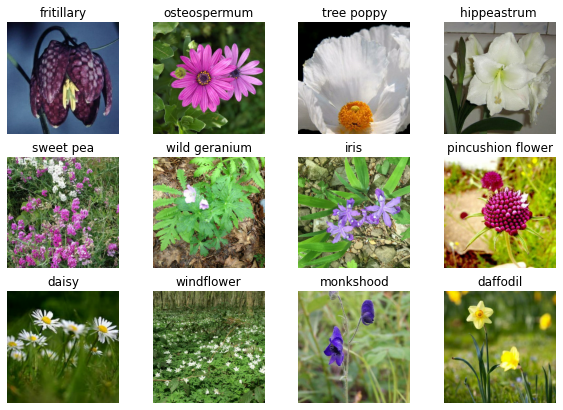

In [9]:
plt.figure(figsize=(10,7))

train_dataset = get_training_dataset(TRAINING_FILENAMES, batch_size=12)
train_iter = iter(train_dataset)
batch = next(train_iter)

for i, image in enumerate(batch[0]):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(image)
    plt.title(CLASSES[batch[1].numpy()[i]])
    plt.axis("off")

Regardons l'utilisation de la data augmentation sur la deuxième image

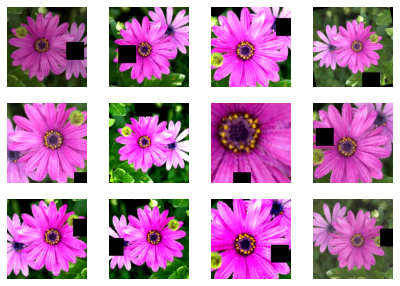

In [10]:
image = batch[0][1]

plt.figure(figsize=(7,5))

for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    img, _ = aug_img(image, "")
    
    plt.imshow(img)
    plt.axis("off")

Les images générées sont bien toutes différentes les unes des autres avec des niveaux de constrate ou de luminosité distincts. 

# EDA

In [ ]:
Nous allons récupérer toutes les images pour analyser les données.

In [11]:
training_dataset = get_training_dataset(TRAINING_FILENAMES, ORIGINAL_NUM_TRAINING_IMAGES)
validation_dataset = get_validation_dataset(NUM_VALIDATION_IMAGES)
extra_dataset = get_training_dataset(EXTRA_FILES, EXTRA_NUM_TRAINING_IMAGES)
train_batch = next(iter(training_dataset))
val_batch = next(iter(validation_dataset))
extra_batch = next(iter(extra_dataset))

Affichons la distribution des labels pour le jeu de données de validation et celui d'entraînement.

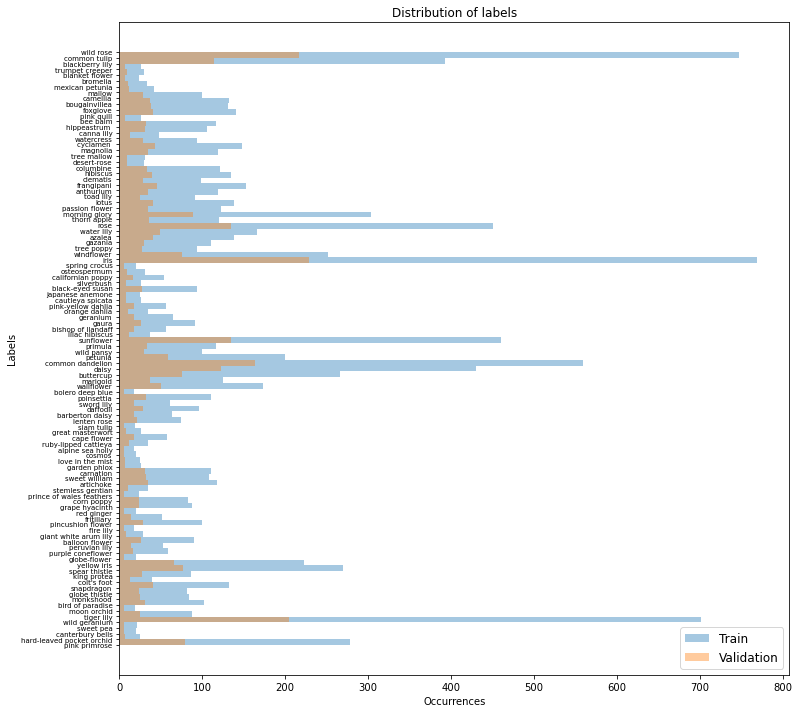

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
ax = sns.distplot(train_batch[1].numpy(), bins=len(CLASSES), kde=False, label='Train', vertical=True)
ax = sns.distplot(val_batch[1].numpy(), bins=len(CLASSES), kde=False, label='Validation', vertical=True)

ax.set_yticks(np.arange(len(CLASSES)))
ax.set_yticklabels(CLASSES, fontsize=7)

plt.legend(prop={'size': 12})
plt.title('Distribution of labels')
plt.xlabel('Occurrences')
plt.ylabel('Labels')
plt.show()

Nous pouvons noter la présence d'imbalance de classes. Cependant, la distribution des deux datasets sont identiques.

Comparons celle d'entraînement à celle des jeux de données supplémentaires.

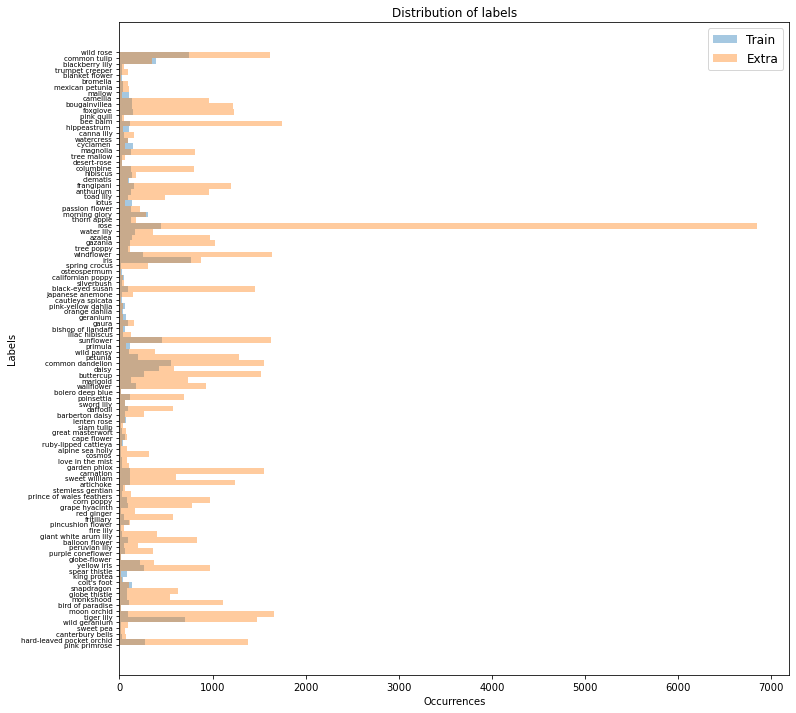

In [13]:
plt.figure(figsize=(12,12))
ax = sns.distplot(train_batch[1].numpy(), bins=len(CLASSES), kde=False, label='Train', vertical=True)
ax = sns.distplot(extra_batch[1].numpy(), bins=len(CLASSES), kde=False, label='Extra', vertical=True)

ax.set_yticks(np.arange(len(CLASSES)))
ax.set_yticklabels(CLASSES, fontsize=7)

plt.legend(prop={'size': 12})
plt.title('Distribution of labels')
plt.xlabel('Occurrences')
plt.ylabel('Labels')
plt.show()

# Traitements

Nous observons que la distribution des images supplémentaires n'est pas exactement pareille à celle d'entraînement.

En effectuant des tests au préalable, il semblerait que les images tests (de soumission) aient la même distribution que celle d'entraînement.

Par conséquent, nous allons utiliser les données supplémentaires en effectuant une correction d'imbalance de classes en ajoutant des coefficients.

In [14]:

class_weights = class_weight.compute_class_weight('balanced', np.unique(extra_batch[1].numpy()), extra_batch[1].numpy())
dict_weights = dict(enumerate(class_weights))
dict_weights

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103], y=[70 94 47 ... 93  5 95] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


{0: 0.38559782608695653,
 1: 7.494718309859155,
 2: 8.86875,
 3: 5.783967391304348,
 4: 0.3600304465493911,
 5: 0.31978665865384615,
 6: 28.00657894736842,
 7: 0.47681451612903225,
 8: 0.9781709558823529,
 9: 0.8433042789223455,
 10: 5.16626213592233,
 11: 16.62890625,
 12: 31.301470588235293,
 13: 0.5474537037037037,
 14: 1.4227941176470589,
 15: 35.475,
 16: 1.482242339832869,
 17: 2.608455882352941,
 18: 0.6418878166465621,
 19: 1.3106527093596059,
 20: 11.321808510638299,
 21: 4.667763157894737,
 22: 0.9335526315789474,
 23: 3.2055722891566263,
 24: 0.6830872913992297,
 25: 0.5468910585817061,
 26: 4.326219512195122,
 27: 9.174568965517242,
 28: 0.4277532154340836,
 29: 0.8795454545454545,
 30: 0.34198264781491,
 31: 5.42984693877551,
 32: 6.489329268292683,
 33: 1.668103448275862,
 34: 6.260294117647059,
 35: 17.7375,
 36: 6.735759493670886,
 37: 7.601785714285715,
 38: 12.375,
 39: 9.01906779661017,
 40: 2.038793103448276,
 41: 0.9190414507772021,
 42: 8.446428571428571,
 43: 0.7

Une technique utilisé est le learning rate schedule où le taux d'apprentissage progresse lentement en fonction du numéro de batch courant pour ensuite effectuer une descente exponentielle.

Learning rate schedule: 1e-05 to 0.0004 to 1e-05


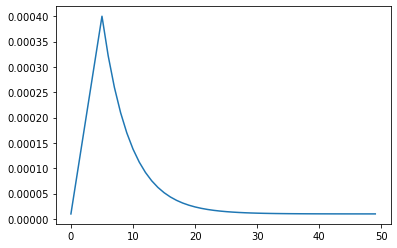

In [15]:
# Learning rate schedule for TPU, GPU and CPU.
# Using an LR ramp up because fine-tuning a pre-trained model.
# Starting with a high LR would break the pre-trained weights.

LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

rng = [i for i in range(50)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Modèles

## DenseNet201

In [16]:
training_dataset = get_training_dataset(TRAINING_FILENAMES, BATCH_SIZE, augmentation=True)
validation_dataset = get_validation_dataset(BATCH_SIZE)
training_dataset_extra = get_training_dataset(EXTRA_FILES, BATCH_SIZE, augmentation=True)

with strategy.scope():    

    base_model = tf.keras.applications.DenseNet201(weights='imagenet', include_top = False, input_shape=[*IMAGE_SIZE, 3])
    base_model.trainable = True

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])

model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)


history = model.fit(training_dataset_extra, 
          steps_per_epoch=STEPS_PER_EPOCH_EXTRA, 
          epochs=3, 
          validation_data=validation_dataset,
          class_weight=dict_weights,                    
          callbacks=[lr_callback]
)


history = model.fit(training_dataset, 
          steps_per_epoch=STEPS_PER_EPOCH, 
          epochs=50, 
          validation_data=validation_dataset,                    
          callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=5), lr_callback]
)

74842112/74836368 [==============================] - 1s 0us/step

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/3
432/432 [==============================] - 111s 257ms/step - sparse_categorical_accuracy: 0.1078 - loss: 4.2077 - val_sparse_categorical_accuracy: 0.2559 - val_loss: 3.6035 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/3
432/432 [==============================] - 84s 194ms/step - sparse_categorical_accuracy: 0.5624 - loss: 1.6603 - val_sparse_categorical_accuracy: 0.5577 - val_loss: 1.8300 - lr: 8.8000e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/3
432/432 [==============================] - 87s 201ms/step - sparse_categorical_accuracy: 0.7275 - loss: 0.8162 - val_sparse_categorical_accuracy: 0.6455 - val_loss: 1.4451 - lr: 1.6600e-04

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/50
99/99 [==============================] - 22s 

## EfficientNetB7

In [17]:
with strategy.scope():    

    base_model = efficientnet.EfficientNetB7(weights='noisy-student', include_top = False, input_shape=[*IMAGE_SIZE, 3])
    base_model.trainable = True

    model2 = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])

model2.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)


history = model2.fit(training_dataset_extra, 
          steps_per_epoch=STEPS_PER_EPOCH_EXTRA, 
          epochs=3, 
          validation_data=validation_dataset,
          class_weight=dict_weights,                    
          callbacks=[lr_callback]
)

history = model2.fit(training_dataset, 
          steps_per_epoch=STEPS_PER_EPOCH, 
          epochs=50, 
          validation_data=validation_dataset,                    
          callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=5), lr_callback]
)

258072576/258068648 [==============================] - 8s 0us/step

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/3
432/432 [==============================] - 154s 357ms/step - sparse_categorical_accuracy: 0.0147 - loss: 4.6419 - val_sparse_categorical_accuracy: 0.0151 - val_loss: 4.5916 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/3
432/432 [==============================] - 126s 292ms/step - sparse_categorical_accuracy: 0.2106 - loss: 3.6474 - val_sparse_categorical_accuracy: 0.3763 - val_loss: 2.7314 - lr: 8.8000e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/3
432/432 [==============================] - 126s 291ms/step - sparse_categorical_accuracy: 0.4852 - loss: 1.8563 - val_sparse_categorical_accuracy: 0.5908 - val_loss: 1.5966 - lr: 1.6600e-04

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/50
99/99 [==============================] - 

## Stacking

Pour utiliser la méthode ensembliste, il faut déterminer un coefficient permettant de déterminer la meilleure balance entre les deux modèles.

Pour cela, nous allons utiliser le dataset de validation pour comparer les résultats.

In [18]:
cmdataset = get_validation_dataset(BATCH_SIZE, ordered=True) # since we are splitting the dataset and iterating separately on images and labels, order matters.
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()
cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() # get everything as one batch
m1 = model.predict(images_ds)
m2 = model2.predict(images_ds)

cm_predictions = np.argmax(m1, axis=-1)
print("M1:", f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro'))

cm_predictions = np.argmax(m2, axis=-1)
print("M2:", f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro'))

scores = []
for alpha in np.linspace(0,1,100):
    cm_probabilities = alpha*m1+(1-alpha)*m2
    cm_predictions = np.argmax(cm_probabilities, axis=-1)
    scores.append(f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro'))

    best_alpha = np.argmax(scores)/100
print('Best alpha:', str(best_alpha))

M1: 0.8830905525712885
M2: 0.9095079988826437
Best alpha: 0.49


Cet alpha sera donc conservé pour les prédictions.

Regardons le matrice de confusion.

# Error Analysis

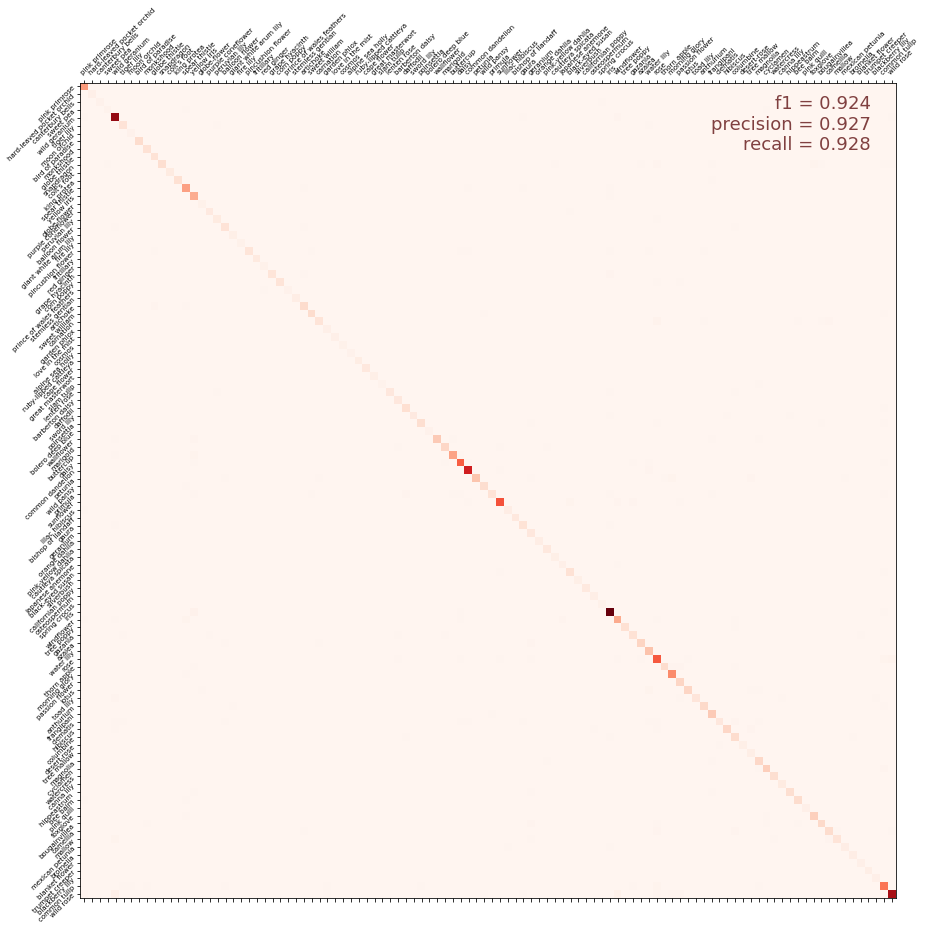

f1 score: 0.924, precision: 0.927, recall: 0.928


In [19]:
def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()

cm_probabilities = best_alpha*m1 + (1-best_alpha)*m2
cm_predictions = np.argmax(cm_probabilities, axis=-1)
cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
#cmat = (cmat.T / cmat.sum(axis=1)).T # normalized
display_confusion_matrix(cmat, score, precision, recall)
print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))


Les classes ayant le plus d'instances sont celles qui ont eu de meilleures bonnes prédictions.

Test Time Augmentation est également employé. Cette technique consiste à utiliser la data augmentation sur les fichiers tests.

# Test Time Augmentation

In [20]:
def tta_data_aug(images):
    img = tf.image.random_brightness(images, 0.1)
    img = tf.image.random_contrast(img, 0.8, 2.2)
    
    rand_rad = np.random.uniform(-np.pi / 6, np.pi / 6)
    img = tfa.image.rotate(img, rand_rad)
    rand_zoom = np.random.uniform(0, 0.2)
    img = tf.image.central_crop(img, 1 - (rand_rad**2 + rand_zoom))
    img = tf.image.resize(img, IMAGE_SIZE)
    
    img = tf.image.random_flip_left_right(img)
    
    img = tfa.image.random_cutout(img, SIZE_CUTOUT)
    
    return img



def tta_predictions(model, model2, ds, n):
    probs  = []
    probs2 = []
    for i in range(n):
        ds_tta = ds.map(tta_data_aug, num_parallel_calls=tf.data.experimental.AUTOTUNE)        
        probs.append(model.predict(ds_tta))
        probs2.append(model2.predict(ds_tta))
        
    return probs, probs2



# Soumission

Prédiction des images tests pour la soumission

In [ ]:
cmdataset = get_validation_dataset(BATCH_SIZE, ordered=True) # since we are splitting the dataset and iterating separately on images and labels, order matters.
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()
cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() # get everything as one batch
m1, m2 = tta_predictions(model, model2, images_ds, 5)

m1 = np.mean(m1, axis=0)
m2 = np.mean(m2, axis=0)

cm_predictions = np.argmax(m1, axis=-1)
print("M1:", f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro'))

cm_predictions = np.argmax(m2, axis=-1)
print("M2:", f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro'))

scores = []
for alpha in np.linspace(0,1,100):
    cm_probabilities = alpha*m1+(1-alpha)*m2
    cm_predictions = np.argmax(cm_probabilities, axis=-1)
    scores.append(f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro'))

    best_alpha = np.argmax(scores)/100
print('Best alpha:', str(best_alpha))


test_ds = get_test_dataset(BATCH_SIZE)
test_images_ds = test_ds.map(lambda image, idnum: image)
m1, m2 = tta_predictions(model, model2, test_images_ds, 5)
probs1 = np.mean(m1, axis=0)
probs2 = np.mean(m2, axis=0)
probabilities = best_alpha*probs1 + (1-best_alpha)*probs2
predictions = np.argmax(probabilities, axis=-1)

test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')

M1: 0.939250586671085
M2: 0.9314956659190543
Best alpha: 0.74
